<a href="https://colab.research.google.com/github/oziomaozigbo/SMCR/blob/main/Earth_Heat_2Nrevsyssimgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import numpy as np , matplotlib.pyplot as plt

# Earth Heat 2N

In [90]:
# ODE4U function
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
                 returns state derivative and output as arrays
        time   : time values at which the solution is computed.
                 p-dimensional array
        x0     : n-dimensional array, state at time[0].
        u      : (m x p) dimensional array
                 optional input sampled at each time step.
        c      : optional constants passed to odefun.

    Returns:
        time   : ndarray, shape (1, p)
        x_sol  : ndarray, shape (n, p)
        x_drv  : ndarray, shape (n, p)
        y_sol  : ndarray, shape (m, p)
    """

    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time) # the total number of time steps

    # create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    # verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    # state derivitives and outputs at time[0]
    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size                 # number of states
    m = np.asarray(y0).size     # nuber of outputs

    # allocate memory
    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0    # states
    x_drv[:, 0] = dxdt0 # state derivitives
    y_sol[:, 0] = y0    # outputs

    for p in range(points - 1):  # time stepping loop and main integration
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        # intermediate dervitives
        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        # state update using the intermediate derivities
        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        # state derivitives and outputs at start of time (p+1)
        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        # save states (solution), state derivitives, and outputs
        x_sol[:, p+1] = x0    # state
        x_drv[:, p+1] = dxdt1 # state derivitives
        y_sol[:, p+1] = y0    # output

        # safety - incase NaN or Inf
#       if not np.all(np.abs(x0) > 1e12):
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol

ao__dz =  250.0
Computed c.ocn_ahc (per layer array) shape: (8,)
Surface heat-transfer coefficients (W/m²·K):
  H_atm (surface) = 0.500,  H_atm (top) ~ 0.1301
  H_ocn (surface) = 4.000,  H_ocn (bottom) ~ 0.1991
  H_ocn_atm (interface) = 40.000
time_step= 2.0 hr ...  number of time steps= 70080
Year=  11.0
T_atm surface (deg C)  =  33.3253715899408
T_ocn surface (deg C)  =  37.652761815949475
T_ocn bottom (deg C)   =  3.07826235867293


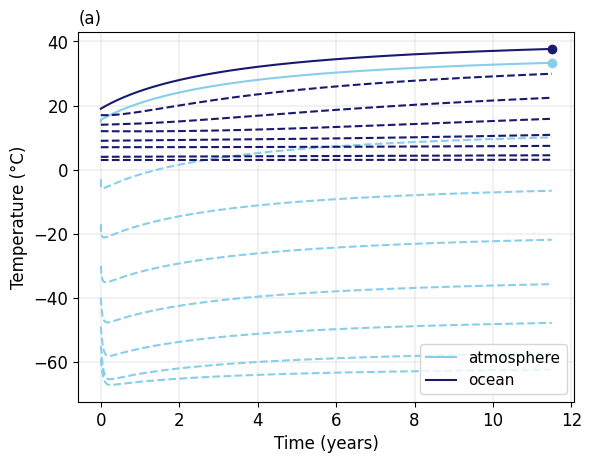

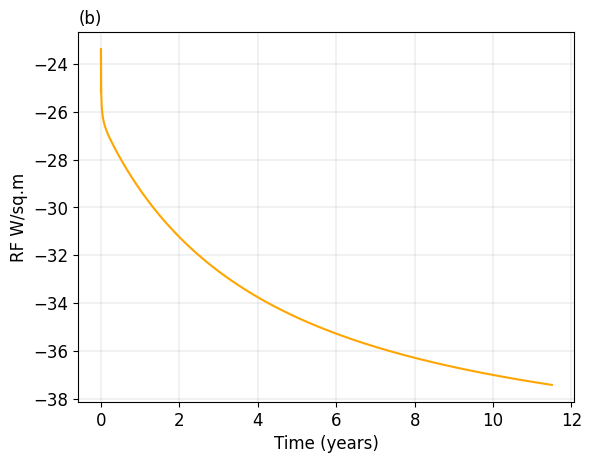

In [91]:
#!/usr/bin/env python3

import numpy as np, matplotlib.pyplot as plt

# 2N layer heat energy model for the earth's oceans and atmosphere
# ... (links removed for brevity) ...


# planetary constants
# -------------------
class c:
    pi  =   np.pi
    c   =  299.792458e6         # speed of light  m/s
    h   =    6.62607015e-34     # Planck's constant  J/Hz
    k   =    1.380649e-23       # Boltzmann's constant J/deg K
    sbc =    5.670367e-8        # Stefan-Boltzman constant  ... W/sq.m/deg K^4
    Ts  = 5777.                 # sun temperature, K
    Rs  =    6.9570e08          # radius of sun, m
    D   =    1.4960e11          # sun - to - earth distance, m
    Re  =    6.3567523e6        # radius of earth, m
    sec_per_yr = 365*24*3600    # seconds per year

    # radiative properties / default params
    aa     =  0.35            # earth albedo (will be tuned later)
    ee_atm =  0.78            # atmos emissivity
    ee_ocn =  0.96            # ocean emissivity

    years  = 16                 # years in the simulation
    n_layer = 8                 # number of layers in atmosphere and ocean

    # stratosphere and thermophysical constants
    T_strat = 273 - 60          # temperature of the stratosphere, K
    atm_density_s = 1.23        # density of air at sea level kg/cu.m
    atm_density_t = 0.32        # density of air at top of troposphere kg/cu.m
    atm_shc = 1003              # specific heat capacity of air J/(kg K)
    atm_heat_transfer = 0.5     # base atm heat-transfer coefficient (W/m2 K), will be used as surface H0
    atm_elvtn = 12650           # depth of troposphere m

    # ocean/land properties
    ocn_atm_heat_transfer = 40  # base air-sea interface heat transfer (W/m2 K)
    ocn_shc = 4000              # seawater specific heat capacity J/(kg K)
    ocn_density = 1023.6        # seawater density kg/cu.m
    ocn_heat_transfer = 4.0     # base internal ocean H (W/m2 K)
    ocn_depth = 3150            # average ocean depth m
    land_thickness = 8.4        # equivalent water thickness of land, m
    land_area_fraction = 0.292  # fraction of earth that is land

    # computed constants (arrays dependent on n_layer)
    solar_const = sbc*Ts**4.0 * 4*pi*Rs**2 / (4*pi*D**2.0) # solar constant W/m^2

    # vertical coordinates for atm and ocean (layer boundaries)
    atm_z = atm_elvtn * np.hstack([0, np.logspace(-1.5, 0.0, n_layer)])   # boundaries
    ocn_z = ocn_depth * np.hstack([0, -np.logspace(-1.5, 0.0, n_layer)])  # boundaries (negative downward)

    # layer thicknesses (arrays length n_layer)
    atm_tz = atm_z[1:n_layer+1] - atm_z[0:n_layer]
    ocn_tz = ocn_z[0:n_layer] - ocn_z[1:n_layer+1]

    # approximate layer-center distances for flux calculations
    atm_dz = 0.5*(atm_z[2:n_layer+1] - atm_z[0:n_layer-1])
    ocn_dz = 0.5*(ocn_z[0:n_layer-1] - ocn_z[2:n_layer+1])
    ao__dz = 0.5*(atm_z[1] - ocn_z[1])  # distance between lowest atm layer center and ocean surface

    print("ao__dz = ", np.round(ao__dz))

    # atmospheric density exponential decay parameters (used to set scale height)
    atm_density_decay = atm_elvtn / np.log(atm_density_s / atm_density_t)
    atm_density = atm_density_s * np.exp(-(atm_z[0:n_layer] + 0.5*atm_tz) / atm_density_decay)

    # troposphere area heat capacity (per sq.m) J/(sq.m K)
    atm_ahc = atm_shc * atm_density * atm_tz

    # ocean area heat capacity (per sq.m) J/(sq.m K) -- note ocn_tz is array
    # We'll compute effective ocn_ahc after class definition so we can use c.* properly

# -----------------------------
# Derived constants (after class c exists)
# -----------------------------
# Effective ocean + land heat capacity (J/m²·K)
# weight ocean mixed-layer capacity by ocean area and land by equivalent water thickness
c.ocn_ahc = ((1.0 - c.land_area_fraction) * c.ocn_shc * c.ocn_density * c.ocn_tz +
             c.land_area_fraction * c.ocn_shc * c.ocn_density * c.land_thickness)

# For spatially-varying H we set scale heights; for atm use the density-decay scale,
# for ocean choose a reasonable decay scale (order 1e3 m)
c.H_scale_atm = c.atm_density_decay        # m (scale for atmospheric H)
c.H_scale_ocn = max(300.0, c.ocn_depth/3.) # m (mixing decays with depth; avoid too small)

# We will use the base heat-transfer coefficients as the *surface* (z=0) values:
c.H_atm0 = c.atm_heat_transfer       # at sea level (W/m2 K)
c.H_ocn0 = c.ocn_heat_transfer       # at top ocean (W/m2 K)
c.H_ocn_atm = c.ocn_atm_heat_transfer# air-sea interface H (W/m2 K)

# Tuned parameters (you already tuned previously; keep them as final defaults)
c.aa = 0.29
c.ee_atm = 0.78
c.ee_ocn = 0.96
c.atm_heat_transfer = c.H_atm0
c.ocn_heat_transfer = c.H_ocn0
c.ocn_atm_heat_transfer = c.H_ocn_atm

print("Computed c.ocn_ahc (per layer array) shape:", np.shape(c.ocn_ahc))
print("Surface heat-transfer coefficients (W/m²·K):")
print(f"  H_atm (surface) = {c.H_atm0:.3f},  H_atm (top) ~ {c.H_atm0*np.exp(-(np.max(c.atm_z)/c.H_scale_atm)):.4f}")
print(f"  H_ocn (surface) = {c.H_ocn0:.3f},  H_ocn (bottom) ~ {c.H_ocn0*np.exp(-c.ocn_depth/c.H_scale_ocn):.4f}")
print(f"  H_ocn_atm (interface) = {c.H_ocn_atm:.3f}")

# -----------------------------
# ODE system (revised to use spatially-varying H)
# -----------------------------
def sys(t, x, u, c):
    """
    compute the state derivives dxdt given current state, time, and input
    x = [ Q_atm , Q_ocn ] states ... heat in atmosphere and ocean J/sq.m
    Uses spatially-varying heat transfer coefficients that decay exponentially with height/depth.
    """

    N  = c.n_layer

    # extract states (heat per m^2) and convert to temperature (K)
    Q_atm = x[0:N]
    Q_ocn = x[N:2*N]

    T_atm = np.maximum(0.0, Q_atm / c.atm_ahc)    # atmosphere temperatures [K], array length N
    T_ocn = np.maximum(0.0, Q_ocn / c.ocn_ahc)    # ocean temperatures [K], array length N

    # compute layer centers (heights/depths)
    z_atm_centers = c.atm_z[0:N] + 0.5 * c.atm_tz      # m above surface
    z_ocn_centers = np.abs(c.ocn_z[0:N] - 0.5 * c.ocn_tz)  # m below surface (positive depth)

    # spatially-varying H (exponential)
    H_atm_profile = c.H_atm0 * np.exp(- z_atm_centers / c.H_scale_atm)    # W/m2/K for each atm layer
    H_ocn_profile = c.H_ocn0 * np.exp(- z_ocn_centers / c.H_scale_ocn)    # W/m2/K for each ocn layer

    # allocate derivatives
    dQ_atm_dt = np.ones(N) * np.nan
    dQ_ocn_dt = np.ones(N) * np.nan

    # ---------------- Atmosphere heat computation ----------------
    # We'll follow the same radiative framework as before, but replace constant h_L/h_U
    # by interface H's computed from profiles (averaging adjacent layer H's)
    R_out_U = c.ee_ocn * c.sbc * T_ocn[0]**4.0  # upward radiation from surface (initial)
    for k in range(N):
        # interface H (lower and upper) as averages of adjacent H profile values
        if k == 0:
            # lower interface between ocean surface and lowest atm layer:
            h_L = c.ocn_atm_heat_transfer   # use specified air-sea interface coefficient
        else:
            # approx H between layer k and layer below (avg)
            h_L = 0.5 * (H_atm_profile[k] + H_atm_profile[k-1])

        if k == N-1:
            # uppermost layer exchanges with stratosphere; set h_U from local H
            h_U = H_atm_profile[k]
            T_U = c.T_strat
        else:
            h_U = 0.5 * (H_atm_profile[k] + H_atm_profile[k+1])
            T_U = T_atm[k+1]

        # lower temperature
        if k == 0:
            T_L = T_ocn[0]   # ocean surface
        else:
            T_L = T_atm[k-1]

        # Radiative terms (unchanged logic)
        R_in_L  = R_out_U
        R_in_U  = c.ee_atm * c.sbc * T_U**4.0
        R_out_L = (1 - c.ee_atm) * R_in_U + c.ee_atm * c.sbc * T_atm[k]**4.0
        R_out_U = (1 - c.ee_atm) * R_in_L + c.ee_atm * c.sbc * T_atm[k]**4.0

        # rate of change in heat within atmosphere layer number "k"
        dQ_atm_dt[k] = R_in_L + R_in_U - R_out_L - R_out_U \
                       + h_L * (T_L - T_atm[k]) + h_U * (T_U - T_atm[k])

    # ---------------- Ocean heat computation ----------------
    for k in range(N):
        # interface H between ocean layers (upper and lower) using ocean H profile
        if k == 0:
            # upper interface between ocean top layer and atmosphere
            h_U = c.ocn_atm_heat_transfer
            T_U = T_atm[0]
            # include shortwave solar u input at surface later via u[0]
        else:
            h_U = 0.5 * (H_ocn_profile[k] + H_ocn_profile[k-1])
            T_U = T_ocn[k-1]

        if k == N-1:
            # bottom ocean: no lower mixing (insulated or very small)
            h_L = 0.0
            T_L = T_ocn[k]
        else:
            h_L = 0.5 * (H_ocn_profile[k] + H_ocn_profile[k+1])
            T_L = T_ocn[k+1]

        # shortwave + radiative + transmitted longwave input at surface only (k==0)
        u0 = 0.0
        if k == 0:
            # net shortwave available to the ocean surface — u is given in W/m2
            # We subtract outgoing longwave emitted by ocean surface (emissivity*σ*T^4)
            # and add radiative inputs from atmosphere as in original code:
            u0 = u[0] - c.ee_ocn * c.sbc * T_ocn[0]**4.0 \
                 + (1 - c.ee_atm) * c.sbc * T_atm[1]**4.0 \
                 + c.ee_atm * c.sbc * T_atm[0]**4.0

        # rate of change in heat within ocean layer number "k"
        dQ_ocn_dt[k] = u0 + h_L * (T_L - T_ocn[k]) + h_U * (T_U - T_ocn[k])

    # Radiative Forcing output (weighted surface flux)
    RF = c.sbc * ((1 - c.ee_atm) * T_atm[1]**4.0 + c.ee_atm * T_atm[0]**4.0 \
                  - c.ee_ocn * T_ocn[0]**4.0)

    # state derivative vector (same shape as x)
    dxdt = np.hstack([dQ_atm_dt, dQ_ocn_dt])

    # output vector: temperatures (K) and RF
    y = np.hstack([T_atm, T_ocn, RF])

    return dxdt, y


# -----------------------------
# simulate the dynamical system (unchanged interface, uses new sys internally)
# -----------------------------
def run():
    N = c.n_layer
    # time
    time_end     = c.sec_per_yr  * c.years           # final time, s
    time_step    = c.sec_per_yr  / (12*365)          # time step, s
    n_time       = int(time_end / time_step)
    dt           = time_step * np.ones(n_time)
    n_ramp       = int( c.sec_per_yr * 9 / time_step )
    k_ramp       = np.linspace(0,n_ramp-1,n_ramp)
    dt[0:n_ramp] = time_step*( np.sin(2*np.pi*k_ramp/n_ramp/4) )**2.0
    time         = np.cumsum(dt);

    print("time_step=", time_step/3600, "hr ...  number of time steps=", n_time)

    # initial state values (temperatures in degC -> convert to energy per area using ahc)
    T_atm_init = np.array([15., -3., -17., -30., -40., -49., -55., -59.])
    T_ocn_init = np.array([19., 17., 14., 12., 9., 7., 4., 3.])

    x_init = np.hstack([ c.atm_ahc * (T_atm_init + 273.0), c.ocn_ahc * (T_ocn_init + 273.0) ])

    # external forcing (shortwave at surface) W/m2
    u = (1 - c.aa) * (c.solar_const / 4.0) * np.ones(n_time)

    # call ODE solver
    time_out, x_sol, x_drv, y = ode4u(sys, time, x_init, u, c)

    # convert time to years for plotting & diagnostics
    time_years = time_out / c.sec_per_yr

    # extract temperatures (K -> degC)
    T_atm = y[0:N, :] - 273.0
    T_ocn = y[N:2*N, :] - 273.0
    RF = y[2*N, :]

    # print some results
    print("Year= ", np.round(time_years[-1]))
    print("T_atm surface (deg C)  = ", T_atm[0, -1])
    print("T_ocn surface (deg C)  = ", T_ocn[0, -1])
    print("T_ocn bottom (deg C)   = ", T_ocn[-1, -1])

    # plotting (same as before)
    fontsize = 12
    plt.rcParams['font.size'] = fontsize
    plt.ion()

    f1 = plt.figure(1)
    plt.clf()
    plt.plot(time_years, T_atm[0,:], "-", color='SkyBlue', label="atmosphere")
    plt.plot(time_years, T_ocn[0,:], "-", color='MidnightBlue', label="ocean")
    plt.plot(time_years[-1], T_atm[0,-1], "o", color='SkyBlue')
    plt.plot(time_years[-1], T_ocn[0,-1], "o", color='MidnightBlue')
    for k in range(1,N):
        plt.plot(time_years, T_atm[k,:], "--", color='SkyBlue' )
        plt.plot(time_years, T_ocn[k,:], "--", color='MidnightBlue')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time (years)')
    plt.legend(loc='lower right',fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(a)",loc="left",fontsize=fontsize)

    f2 = plt.figure(2)
    plt.clf()
    plt.plot(time_years, RF, "-", color='Orange')
    plt.ylabel('RF W/sq.m')
    plt.xlabel('Time (years)')
    plt.grid(lw=0.25)
    plt.title("(b)",loc="left",fontsize=fontsize)
    plt.show()

    # return simulation results for programmatic tests
    return time_years, x_sol, x_drv, y

# If run as script, run it
if __name__ == "__main__":
    run()


time_step= 2.0 hr ...  number of time steps= 70080
Year=  11.0
T_atm surface (deg C)  =  33.3253715899408
T_ocn surface (deg C)  =  37.652761815949475
T_ocn bottom (deg C)   =  3.07826235867293


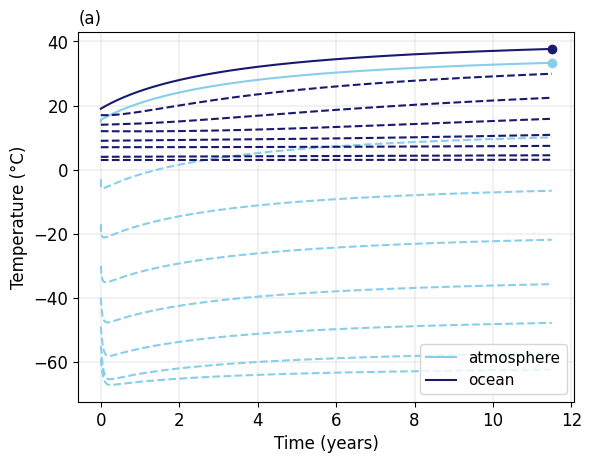

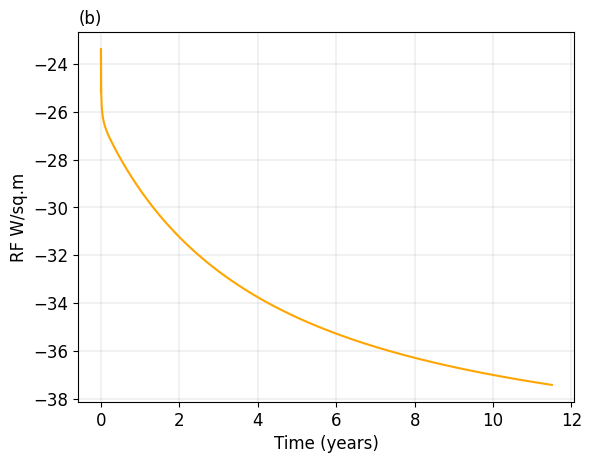

(array([0.00000000e+00, 3.62520361e-13, 1.81260180e-12, ...,
        1.14994292e+01, 1.14996575e+01, 1.14998858e+01]),
 array([[1.39137203e+08, 1.39137203e+08, 1.39137203e+08, ...,
         1.47990393e+08, 1.47990431e+08, 1.47990470e+08],
        [8.03561719e+07, 8.03561719e+07, 8.03561719e+07, ...,
         8.42487376e+07, 8.42487594e+07, 8.42487812e+07],
        [1.20399117e+08, 1.20399117e+08, 1.20399117e+08, ...,
         1.25302372e+08, 1.25302404e+08, 1.25302436e+08],
        ...,
        [3.73990873e+11, 3.73990873e+11, 3.73990873e+11, ...,
         3.74544606e+11, 3.74544628e+11, 3.74544650e+11],
        [6.04219666e+11, 6.04219666e+11, 6.04219666e+11, ...,
         6.05274997e+11, 6.05275017e+11, 6.05275038e+11],
        [9.84306741e+11, 9.84306741e+11, 9.84306741e+11, ...,
         9.84585837e+11, 9.84585844e+11, 9.84585850e+11]]),
 array([[ 3.47964782e+01,  3.47964782e+01,  3.47964781e+01, ...,
          5.33765676e-03,  5.33749538e-03,  5.33733401e-03],
        [-1.45232083

In [92]:
run()